Ablation for Symphony resolution on QM9!

In [30]:
from typing import *
import matplotlib.pyplot as plt
import seaborn as sns
import jax
import jax.numpy as jnp
import chex
import functools
import pandas as pd
import e3nn_jax as e3nn
import posebusters
import sys
import os
import ase
import ase.io
import rdkit.Chem as Chem
import nglview as nv
sys.path.append("../..")

In [31]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
%autoreload 2
import sys
sys.path.append("..")
from analyses.metrics import *

Paths:

In [41]:
generated_paths = {}
template = "/Users/ameyad/Documents/spherical-harmonic-net/analyses/analysed_workdirs/qm9_bessel_embedding_attempt6_edm_splits_iclr2024_submission/e3schnet_and_nequip/interactions=3/l=5/position_channels=2/channels=64/fait=1.0/pit=1.0/step=9930000_res_alpha={res_alpha}_res_beta={res_beta}/molecules"
for res_alpha in [89, 179, 359, 719]:
    for res_beta in [45, 90, 180, 360]:
            path = template.format(res_alpha=res_alpha, res_beta=res_beta)
            assert os.path.exists(path)
            generated_paths[(res_alpha, res_beta)] = path

Corresponding molecules:

In [42]:
all_generated_molecules = {
    model: get_all_molecules(path) for model, path in generated_paths.items()
}

valid_molecules = {
    model: get_all_valid_molecules(molecules) for model, molecules in all_generated_molecules.items()
}

Validity for model (89, 45): 0.8312
Validity for model (89, 90): 0.8326
Validity for model (89, 180): 0.8347
Validity for model (89, 360): 0.8317
Validity for model (179, 45): 0.8334
Validity for model (179, 90): 0.8374
Validity for model (179, 180): 0.8325
Validity for model (179, 360): 0.8384
Validity for model (359, 45): 0.8323
Validity for model (359, 90): 0.8311
Validity for model (359, 180): 0.8303
Validity for model (359, 360): 0.8319
Validity for model (719, 45): 0.8336
Validity for model (719, 90): 0.8331
Validity for model (719, 180): 0.8313


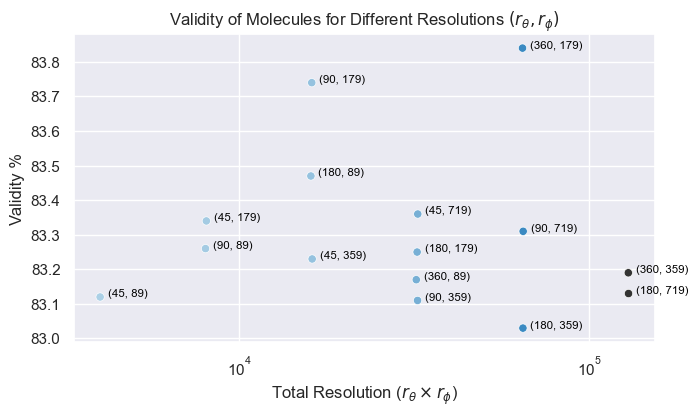

In [48]:
# Make a dataframe for each model for the validity of the molecules.
validity_df = pd.DataFrame(columns=["res_alpha", "res_beta", "validity"])

for model, molecules in valid_molecules.items():
    if len(molecules) == 0:
        continue
    validity_fraction = compute_validity(all_generated_molecules[model], molecules)
    print(f"Validity for model {model}: {validity_fraction}")
    res_alpha, res_beta = model

    validity_df = pd.concat(
        [
            validity_df,
            pd.DataFrame.from_records(
                [
                    {
                        "res_alpha": res_alpha,
                        "res_beta": res_beta,
                        "validity": validity_fraction,
                    }
                ]
            ),
        ],
        ignore_index=True,
    )

# Plot the validity of the molecules for each resolution.
# Let the legend column be the product of the res_alpha and res_beta.
validity_df['legend'] = validity_df['res_alpha'] * validity_df['res_beta']
validity_df['validity_percent'] = validity_df['validity'] * 100.

plt.figure(figsize=(7.5, 4))
sns.set_theme(style="darkgrid")
sns.scatterplot(
    data=validity_df, x="legend", y="validity_percent",
    hue="legend",
    palette="Blues_d",
)
plt.title(r"Validity of Molecules for Different Resolutions $(r_\theta, r_\phi)$")
plt.xlabel(r"Total Resolution ($r_\theta \times r_\phi$)")
plt.ylabel("Validity %")
# Remove legend
plt.legend([],[], frameon=False)
#  # plt.legend(bbox_to_anchor=(1.05, 0.5), loc="center left", borderaxespad=0., title=r"Total Resolution ($r_\theta \times r_\phi$)")
# Add a text annotation for each point, indicating (res_alpha, res_beta).
for _, row in validity_df.iterrows():
    plt.text(
        row['legend'] * 1.05,
        row['validity_percent'],
        f"({row['res_beta']}, {row['res_alpha']})",
        horizontalalignment='left',
        size='x-small',
        color='black',
    )
plt.xscale('log')
plt.savefig("pdfs/validity_vs_resolution.pdf", dpi=500, bbox_inches='tight')
plt.show()

In [ ]:
formatted_validity_df = validity_df.transpose()
formatted_validity_df.columns = formatted_validity_df.iloc[0]
formatted_validity_df *= 100
formatted_validity_df = formatted_validity_df.drop("model")
formatted_validity_df = formatted_validity_df.astype(float)
formatted_validity_df = formatted_validity_df.round(2)
formatted_validity_df = formatted_validity_df.astype(str)
print(formatted_validity_df.style.to_latex())

KeyError: "['model'] not found in axis"